In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import statsmodels
from statsmodels.tsa.stattools import adfuller
import time
import math 


# read train data file 
df_train = pd.read_csv(r'data/ffd_train_split2018-01-01.csv').set_index('Date')
# read test data file
df_test = pd.read_csv(r'data/ffd_test_split2018-01-01_end2019-01-01.csv').set_index('Date')
# split date
split_date = df_test.index[0]
# concat df_train and df_test since we perform transformation on both set using the same clusters
df = pd.concat([df_train, df_test], axis=0)
df.drop(columns=['VXUS'],inplace=True)
display(df)

,RAY,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,EEM,VIX
Date,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.24
1990-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.19
1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.22
1990-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.11
1990-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.26
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,-0.273546,0.169696,-0.312136,5.713054,36.372333,81.287335,2.418022,13.954414,0.568579,26.835077,36.07
2018-12-26,77.749107,10.253434,0.097014,9.804212,40.738189,81.136961,2.669372,16.728878,0.564725,27.620274,30.41
2018-12-27,61.960664,7.605217,0.065795,7.815269,35.815890,87.416785,2.786645,16.492451,0.572821,27.552075,29.96


In [13]:
#manually import all models and put those into a dictionary
model_dict = {}
#load model syntax
import pickle
#VIX
filename = root+'/temporal cluster/temporal clusterVIX_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VIX'] = [model,2,60] #[model,k,win_size]
#CL1
filename = root+'/temporal cluster/temporal clusterCL1_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['CL1'] = [model,2,60] #[model,k,win_size]
#EEM
filename = root+'/temporal cluster/temporal clusterEEM_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['EEM'] = [model,2,60] #[model,k,win_size]
#EURtoUSD
filename = root+'/temporal cluster/temporal clusterEURtoUSD_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['EURtoUSD'] = [model,2,60] #[model,k,win_size]
#GC1
filename = root+'/temporal cluster/temporal clusterGC1_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['GC1'] = [model,2,20] #[model,k,win_size]
#HG1
filename = root+'/temporal cluster/temporal clusterHG1_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['HG1'] = [model,2,20] #[model,k,win_size]
#QQQ
filename = root+'/temporal cluster/temporal clusterQQQ_k3_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['QQQ'] = [model,3,20] #[model,k,win_size]
#RAY
filename = root+'/temporal cluster/temporal clusterRAY_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['RAY'] = [model,2,20] #[model,k,win_size]
#T10Y3M
filename = root+'/temporal cluster/temporal clusterT10Y3M_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['T10Y3M'] = [model,2,20] #[model,k,win_size]
#VNQ
filename = root+'/temporal cluster/temporal clusterVNQ_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VNQ'] = [model,2,20] #[model,k,win_size]
#VXUS
filename = root+'/temporal cluster/temporal clusterVXUS_k2_w60_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['VXUS'] = [model,2,60] #[model,k,win_size]
#XAG
filename = root+'/temporal cluster/temporal clusterXAG_k2_w20_model'
with open(filename , 'rb') as f:
    model = TimeSeriesKMeans.from_pickle(filename)
model_dict['XAG'] = [model,2,20] #[model,k,win_size]

In [14]:
def sliding_window(feature_series,win,step = 1):
    #feature series start from the first valid index
    first_valid= feature_series.first_valid_index()
    feature = feature_series[first_valid:]
    # window construction
    df_feature = pd.DataFrame(columns= [i for i in range(win)])
    for i in range(0, len(feature) - win, step):
        index = feature.index[i+win-1]
        df_feature.loc[index] = feature.iloc[i: i + win].values
    #if the dataframe does not include the last date of the series, add it to make sure we always include newest data
    if (df_feature.index[-1] != feature.index[-1]):
        index = feature.index[-1]
        df_feature.loc[index] = feature.iloc[-(win):].values
    #normalize (minmax)
    df_feature = (df_feature - df_feature.min(1).values.reshape(-1, 1)) / (df_feature.max(1).values.reshape(-1, 1)-df_feature.min(1).values.reshape(-1, 1))
    return df_feature

In [15]:
#find the longest window
longest_win = max([model_dict[i][2] for i in model_dict.keys()])
#find the latest first valid
latest_valid = max([df[col].first_valid_index() for col in df])
#find start point of df
df_start_index = df.reset_index()[df.index == latest_valid].index[0]+longest_win-1
df_start_date = df[df.reset_index().index == df_start_index].index[0]

In [17]:
#now do the loop
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()
for col in df.columns:
    #find the start date of col
    col_win=model_dict[col][2]
    col_start_index = df_start_index-col_win+1
    #create sliding window
    X = sliding_window(df[df.reset_index().index >= col_start_index][col],col_win)
    X_fitted = model_dict[col][0].transform(X)
    df_transform=pd.DataFrame(X_fitted,index = X.index)
    #split into test and train set
    df_train_transform = df_transform[df_transform.index < split_date].add_prefix(col+'_feature')
    df_test_transform = df_transform[df_transform.index >= split_date].add_prefix(col+'_feature')
    df_train_all = pd.concat([df_train_all,df_train_transform],axis = 1)
    df_test_all = pd.concat([df_test_all,df_test_transform],axis = 1)

/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 3161 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data pa

In [18]:
def Graph_cluster(df_feature,model,name):
#     col = min(3,model.n_clusters)
#     row = math.ceil(model.n_clusters/col)
    y_pred = model.predict(df_feature)
    fig, axs = plt.subplots(1,model.n_clusters, figsize=(10,5))
#     if row == 1:
#         axs = np.reshape(axs, (-1, 2))
    for yi in range(model.n_clusters): 
#         #row that subplot belongs
#         rw= math.floor(yi/col)
#         #col that subplot belongs
#         cl = (yi % col)
        axs[yi].plot(df_feature[y_pred == yi].sample(5).T, "k-", alpha=.2)
        axs[yi].plot(model.cluster_centers_[yi], "r-")
        axs[yi].title.set_text(str(name)+" DTW $k$-means Cluster %d"% (yi + 1))
    fig.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7329 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4901 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7029 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6984 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data pa

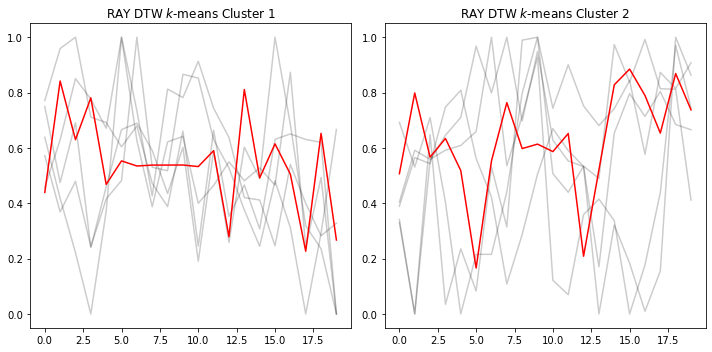

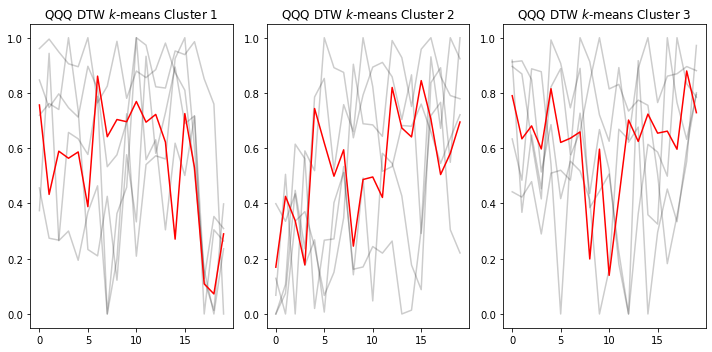

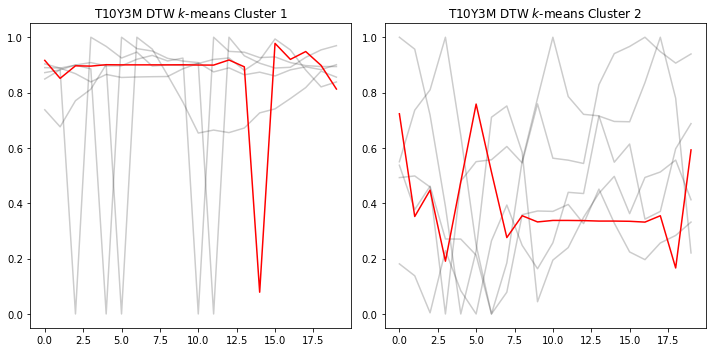

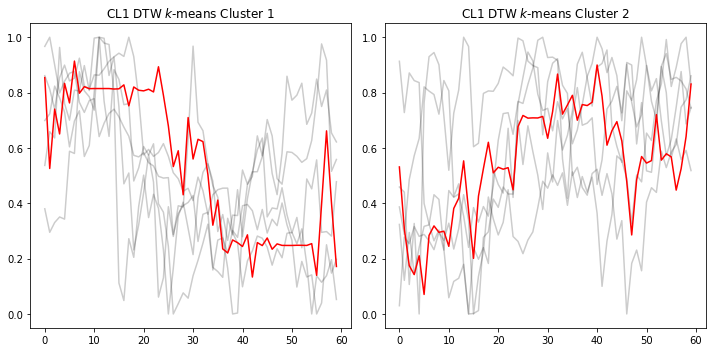

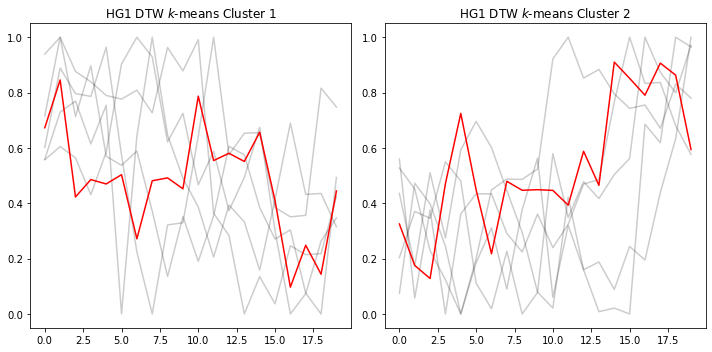

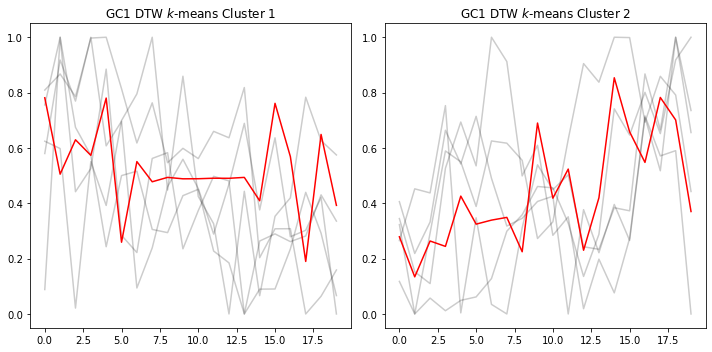

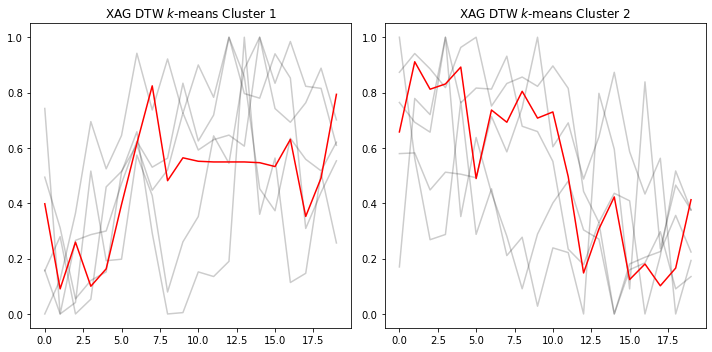

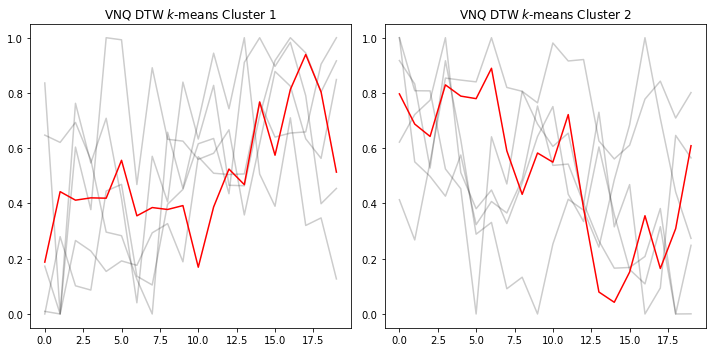

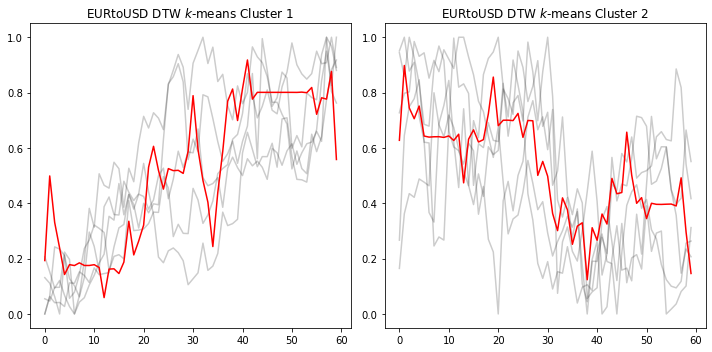

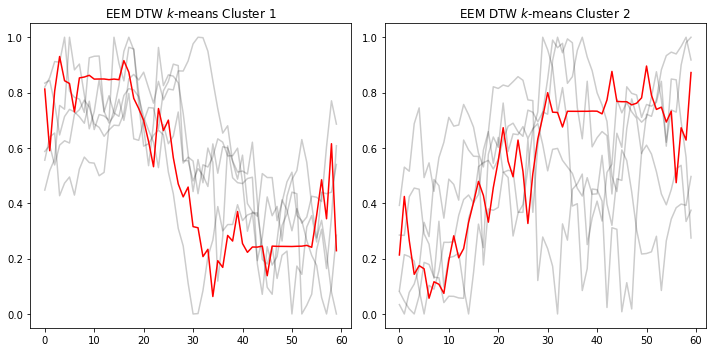

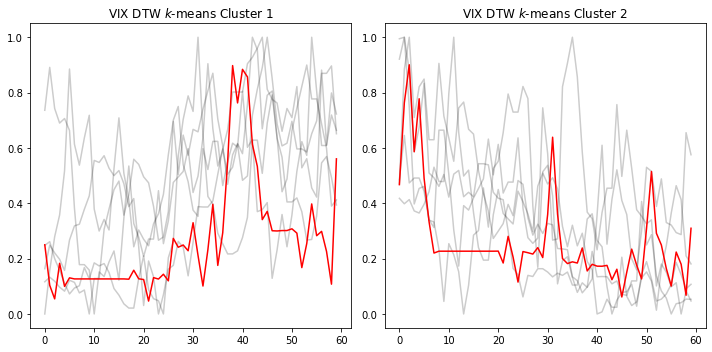

In [19]:
#graphing
for col in df:
    df_feature = sliding_window(df[col],model_dict[col][2])
    Graph_cluster(df_feature,model_dict[col][0],col)

In [7]:
# #PCA
# from sklearn.decomposition import PCA
# #StandardScaler()
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# pca = PCA(0.95)
# df_train_scaled=pd.DataFrame(scaler.fit_transform(df_train_all),index=df_train_all.index)
# df_test_scaled =pd.DataFrame(scaler.transform(df_test_all),index = df_test_all.index)

In [11]:
# df_train_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
2006-11-20,-1.468599,0.180686,-0.054924,-1.874280,-0.013038,1.268657,3.375427,0.698171,0.880348,-1.083577,0.072005,0.820858,-0.326901,-0.259689,0.722769,0.972337,-0.608802,0.457749
2006-11-21,-1.733487,0.151846,-0.207843,-2.060348,0.018448,1.234986,3.145305,0.529799,0.743361,-0.234587,0.148315,1.001652,-0.030239,0.238330,0.881172,0.485949,-0.632096,0.383233
2006-11-22,-1.627475,0.229668,-0.779821,-2.165629,0.412799,1.195860,2.558993,0.662827,1.596657,0.384688,0.724641,0.255570,-0.338214,0.569809,1.120406,0.113365,-0.638838,0.433559
2006-11-23,-2.031659,-0.056689,-1.152826,-1.374651,1.444080,1.043563,2.581384,0.691783,1.134435,-0.804364,0.528426,0.318069,-0.405432,0.403736,0.201117,0.550672,-0.216329,-0.027377
2006-11-24,-1.795646,0.549227,-0.994855,-1.242573,1.251409,1.352439,2.245834,0.857512,-0.333535,-0.632720,0.603376,-0.054666,-0.438374,0.780925,0.241064,0.027256,-0.083807,0.133794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,-1.026265,-0.378299,-0.000240,-1.113620,-0.703561,-0.440652,-2.239160,-0.430094,-0.397611,0.045778,-0.716872,0.023467,-0.008839,0.201862,0.983113,-0.433647,-0.462749,0.366903
2017-12-26,-1.461059,-1.006220,0.607444,0.088844,-0.941907,-0.560383,-2.351520,-0.516876,0.171477,-1.223357,-0.780704,0.018629,-0.463640,0.248247,0.572001,-0.056053,-0.691136,-0.104161
2017-12-27,-1.531783,-0.935915,1.079802,-0.083824,-1.418565,-0.577312,-2.448958,-0.561778,0.185099,-0.176716,-0.798212,0.354911,-0.302437,0.277129,1.422401,-0.630623,-0.743589,-0.315811
2017-12-28,-1.484188,-0.669956,0.967682,0.841224,-0.825008,-0.552578,-2.268456,-0.390691,0.192564,-1.407745,-0.638742,0.111224,-0.661696,0.633324,0.746704,0.019886,-0.651329,-0.388621


In [8]:
# df_train_pca = pd.DataFrame(pca.fit_transform(df_train_scaled),index=df_train_all.index)
# df_test_pca = pd.DataFrame(pca.transform(df_test_scaled),index = df_test_all.index)

In [9]:
# #PCA file
# filename = '/pca_tempfeature_train_split'+str(split_date)+'.csv'
# end_date = df_test_pca.tail(1).index[0]
# df_train_pca.to_csv(root+filename)
# filename = '/pca_tempfeature_test_split'+str(split_date)+'_end'+str(end_date)+'.csv'
# df_test_pca.to_csv(root+filename)

In [20]:
#non PCA file
filename = '/tempfeature_train_split'+str(split_date)+'.csv'
end_date = df_test_all.tail(1).index[0]
df_train_all.to_csv(root+filename)
filename = '/tempfeature_test_split'+str(split_date)+'_end'+str(end_date)+'.csv'
df_test_all.to_csv(root+filename)